<a href="https://colab.research.google.com/github/baovin/ML_homework/blob/main/LetNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Giới thiệu**
- Trong bài tập về nhà lần này, chúng ta sẽ implement mạng LeNet sử dụng PyTorch, và chúng ta sẽ train và đánh giá mô hình trên tập dữ liệu FashionMNIST.
- Dưới đây là kiến trúc mô hình mà chúng ta sẽ implement: ![](https://drive.google.com/uc?export=view&id=1MyiyOZnioz2WegCNjhyv_VXETFPYn_yN)



### **FashionMNIST dataset**
Giới thiệu về Dataset

Fashion-MNIST là một tập dữ liệu về các hình ảnh bài viết của Zalando — bao gồm một tập huấn luyện gồm 60.000 mẫu và một tập test 10.000 mẫu. Mỗi mẫu là một hình ảnh grayscale 28x28, được liên kết với một nhãn từ 10 lớp. Zalando dự định Fashion-MNIST sẽ phục vụ như một sự thay thế trực tiếp cho tập dữ liệu MNIST ban đầu cho các thuật toán máy học điểm chuẩn. Nó có cùng kích thước hình ảnh và cấu trúc của các phần đào tạo và thử nghiệm.

Mỗi hình ảnh có chiều cao 28 pixel và chiều rộng 28 pixel, tổng cộng là 784 pixel. Mỗi pixel có một giá trị pixel duy nhất được liên kết với nó, cho biết độ sáng hoặc tối của pixel đó, với các con số cao hơn có nghĩa là tối hơn. Giá trị pixel này là một số nguyên từ 0 đến 255. Tập dữ liệu đào tạo và kiểm tra có 785 cột. Cột đầu tiên bao gồm các nhãn lớp (xem ở trên) và đại diện cho mặt hàng quần áo. Phần còn lại của các cột chứa các giá trị pixel của hình ảnh được liên kết.

**Label**

0 T-shirt/top

1 Trouser

2 Pullover

3 Dress

4 Coat

5 Sandal

6 Shirt

7 Sneaker

8 Bag

9 Ankle boot

## Import Libraries

In [1]:
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch import optim

## Setup

- Chúng ta sẽ setup một số hyper-parameters cũng như một số giá trị cần dùng theo hướng dẫn nhé
- Ở đây, các bạn vào Runtime, chọn Change the runtime type và chọn GPU nhé.

### Download MNIST dataset in local system

In [2]:
# Định nghĩa tham số transform
transform=transforms.Compose([
    transforms.ToTensor(), # Chuyển ảnh sang dạng Tensor
    transforms.Normalize((0.5,), (0.5,)) # Normalize ảnh với mean và standard deviation là 0.5
    ])

# Load the train and test data
train_set = torchvision.datasets.FashionMNIST(root = "data", train=True, download=True, transform = transform)
test_set = torchvision.datasets.FashionMNIST(root = "data", train=False, download=True, transform = transform)

torch.manual_seed(0)

100%|██████████| 26421880/26421880 [00:01<00:00, 14713580.96it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 316074.19it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2396028.53it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22306071.27it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
# Kiểm thử số chiều của dataset
print('The dimension of the train data:')
print(train_set.data.size())
print('\nThe dimension of the train labels:')
print(train_set.targets.size())

print('\n\nThe dimension of the validation data:')
print(test_set.data.size())
print('\nThe dimension of the validation labels:')
print(test_set.targets.size())

The dimension of the train data:
torch.Size([60000, 28, 28])

The dimension of the train labels:
torch.Size([60000])


The dimension of the validation data:
torch.Size([10000, 28, 28])

The dimension of the validation labels:
torch.Size([10000])


Visualization of FashionMNIST dataset

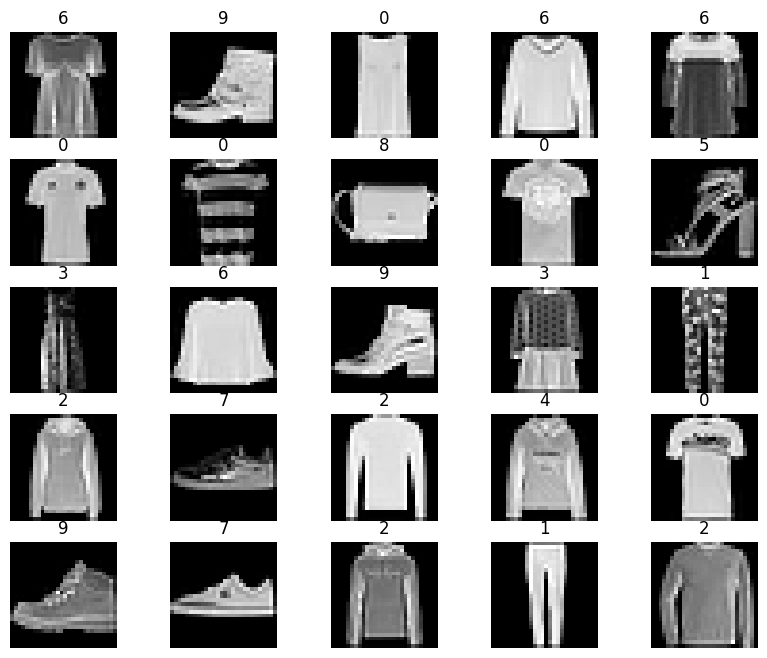

In [4]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Hyperparameters

In [5]:
# Số classes trong tập FashionMNIST
num_classes = 10

# Số epoch
epochs = 2

# Các tham số cần thiết trong quá trình training
learning_rate = 0.001
batch_size = 128
display_step = 100

# Model path
checkpoint = 'model.pth'

# Khởi tạo một số list để lưu loss và accuracy
loss_epoch_array = []
train_accuracy = []
test_accuracy = []
valid_accuracy = []

# device: cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Preparing data for training with DataLoaders
- Để tiện cho việc xử lý dữ dữ liệu vào các batches cũng như reshuffle dữ liệu qua mỗi epoch thì chúng ta sẽ sử dụng hàm sẵn có của PyTorch là [DataLoader](https://pytorch.org/docs/stable/data.html)

In [6]:
train_loader = torch.utils.data.DataLoader(train_set , batch_size=32, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle = False)

## Model

- Dưới đây là kiến trúc mô hình mà chúng ta sẽ implement: ![](https://drive.google.com/uc?export=view&id=1MyiyOZnioz2WegCNjhyv_VXETFPYn_yN)

In [7]:
class CNN_Net(nn.Module):

    def __init__(self):
        super(CNN_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.max_pool1 = nn.MaxPool2d(2, 2)
        self.max_pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 10)
        # self.fc3 = nn.Linear(None, None)
        self.dropout = nn.Dropout(p=0.3)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()

    def forward(self, x):
        ### START CODE HERE ≈ 9-15 lines
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        ### END CODE HERE
        return x

## Training phase



### Training loop

In [8]:
# Định nghĩa hàm khởi tạo tham số
def weights_init(model):
    if isinstance(model, nn.Linear):
        # Xavier Distribution
        torch.nn.init.xavier_uniform_(model.weight)

# Định nghĩa hàm train
def train(dataloader, epoch):
    loss_epoch = 0
    for i, (data,targets) in enumerate(dataloader):
        # Đưa dữ liệu vào GPU
        data, targets = data.to(device), targets.to(device)

        # Clear gradient
        optimizer.zero_grad()

        # Forward pass
        outputs = cnn_net(data)

        # Backpropagation, compute gradients
        loss = loss_function(outputs, targets)
        loss.backward()

        # Apply gradients
        optimizer.step()

        # Lưu lại loss
        loss_epoch += loss.item()
        if i % display_step == 0:
            accuracy = float(test(test_loader))
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}, Accuracy: {:.4f}%'.format(
                epoch + 1, i * 32, len(dataloader.dataset), 100.0 * i / len(dataloader),
                loss.item(), accuracy))
    return loss_epoch

# Định nghĩa hàm test
def test(dataloader):
    test_loss = 0
    correct = 0
    for i, (data, targets) in enumerate(dataloader):
        data, targets = data.to(device), targets.to(device)
        outputs = cnn_net(data)
        _, pred = torch.max(outputs, 1)
        test_loss += targets.size(0)
        correct += torch.sum(pred == targets)
    return 100.0 * correct / test_loss

In [9]:
# Tạo một instance của model và vào GPU
cnn_net = CNN_Net().to(device)

# Khỏi tạo weight với hàm đã tạo
cnn_net.apply(weights_init)

# Sử dụng loss funtion Cross Entropy Loss
loss_function = nn.CrossEntropyLoss()

# Sử dụng Adam optimizer
optimizer = optim.Adam(cnn_net.parameters(), lr=learning_rate)

# Print structure of model
print(cnn_net)

CNN_Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
)


In [10]:
# Driver code to iterate through epochs and store loss and accuracy
for epoch in range(epochs):
    loss_epoch = 0
    loss_epoch = train(train_loader, epoch)
    loss_epoch_array.append(loss_epoch)

    train_accuracy.append(test(train_loader))
    valid_accuracy.append(test(test_loader))
    print("Epoch {}: loss: {:.4f}, train accuracy: {:.4f}, valid accuracy:{:.4f}".format(epoch + 1,
                                        loss_epoch_array[-1], train_accuracy[-1], valid_accuracy[-1]))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.3806, Accuracy: 20.7500%
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.7171, Accuracy: 75.5300%
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.4109, Accuracy: 77.4000%
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.6914, Accuracy: 81.5400%
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.3034, Accuracy: 82.1800%
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.6469, Accuracy: 83.6100%
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.3585, Accuracy: 83.8300%
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.2630, Accuracy: 84.3000%
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.6550, Accuracy: 85.5000%
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.5498, Accuracy: 85.7300%
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.5997, Accuracy: 84.6100%
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.3668, Accuracy: 85.5800%
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.2145, Accuracy: 86.2500%
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.5685, Accuracy: 87.0400%
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.6238, Accuracy

In [11]:
# Plot model history
train_accuracy = [x.cpu().numpy() for x in train_accuracy] # Move tensors to CPU and convert to NumPy
valid_accuracy = [x.cpu().numpy() for x in valid_accuracy] # Move tensors to CPU and convert to NumPy


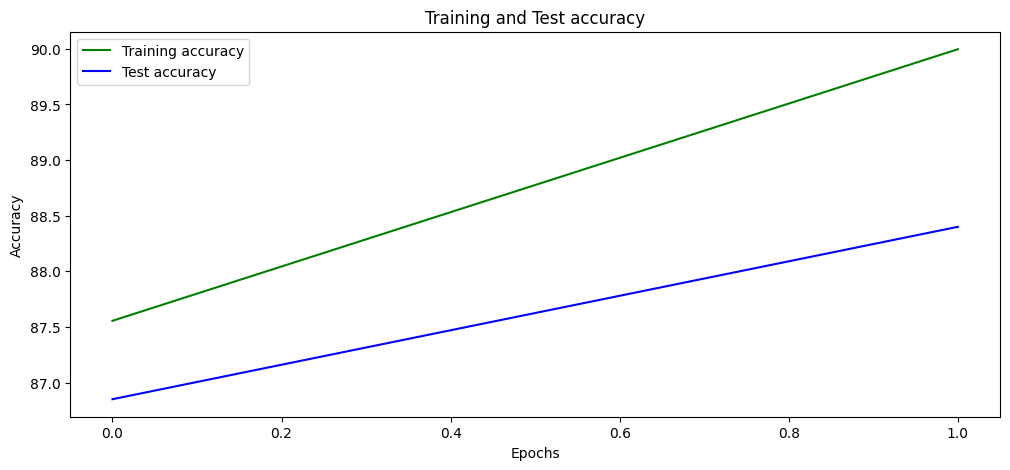

In [12]:
plt.figure(figsize=(12,5))
# plt.rcParams['figure.dpi'] = 300
plt.plot(range(epochs), train_accuracy, 'g', label='Training accuracy')
plt.plot(range(epochs), valid_accuracy, 'b', label='Test accuracy')
plt.title('Training and Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()